# Automatic emittance measurement at LCLS-II
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
from scripts.evaluate_function.lcls_ii_injector import measure_beamsize, measure_background
from scripts.optimize_function import optimize_function
from scripts.characterize_emittance import characterize_emittance

In [ ]:
## import variable ranges
import pandas as pd
VARIABLE_RANGES = pd.read_csv("variable_ranges.csv")
SCREEN_NAME = "OTRS:HTR:330"

## (Optional) Measure background image

In [ ]:
MEASURE_BACKGROUND = True
if MEASURE_BACKGROUND:
    measure_background(SCREEN_NAME)
    BACKGROUND_FILE = f"{SCREEN_NAME}_background.npy"
else:
    BACKGROUND_FILE = None

## Define measurement parameters

In [2]:
from xopt import VOCS
import numpy as np

TUNING_VARIABLES = ["QUAD:HTR:120:BCTRL","QUAD:HTR:140:BACT","QUAD:HTR:300:BACT"]
SCAN_VARIABLE = "QUAD:HTR:320:BACT"
QUAD_LENGTH = 1.0
DRIFT_LENGTH = 1.0
ROI = None
THRESHOLD = None

# define function to measure the total size on OTR4
def eval_beamsize(input_dict):
    results = measure_beamsize(input_dict)
    results["S_x_mm"] = results["Sx"] * 1e3
    results["S_y_mm"] = results["Sy"] * 1e3

    #add total beam size
    results["total_size"] = np.sqrt(results["Sx"]**2 + results["Sy"]**2)



## Optimize upstream beam parameters to minimze beamsize

In [ ]:
opt_vocs = VOCS(
        variables = {VARIABLE_RANGES[ele] for ele in TUNING_VARIABLES},
        constants = {
            SCAN_VARIABLE: 0.0,
            "screen": SCREEN_NAME,
            "background": BACKGROUND_FILE,
            "threshold": THRESHOLD,
            "roi": ROI
        },
        constraints = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", 4]
        },
        objectives = {"total_size": "MINIMIZE"}

    )

opt_x = optimize_function(
    opt_vocs, eval_beamsize, n_iterations=30,
)

In [3]:
opt_x.data

,k1,k2,k3,k4,m11,m22,total_size,xopt_runtime,xopt_error
1,23.672641,-39.285373,1.233360,0.0,1.107901e-06,4.954018e-07,0.001266,0.002350,False
2,1.469849,-68.327274,58.617417,0.0,1.568835e-06,2.286061e-07,0.001341,0.001072,False
3,67.694173,-30.868811,41.737377,0.0,9.842265e-07,1.106740e-05,0.003472,0.001049,False
4,12.176340,-76.900800,90.217882,0.0,1.385770e-07,1.468372e-07,0.000534,0.001042,False
5,7.711672,-9.284325,17.792951,0.0,6.319568e-07,1.964439e-06,0.001611,0.001047,False
6,45.434461,-77.422719,99.986359,0.0,1.060487e-07,1.075281e-06,0.001087,0.001496,False
7,33.194482,-96.097840,12.193043,0.0,2.044478e-06,9.839864e-07,0.001740,0.001168,False
8,22.219325,-49.961566,81.735799,0.0,3.000858e-08,1.914980e-06,0.001395,0.001117,False
9,35.062383,-87.812987,80.948445,0.0,7.310951e-08,8.257631e-08,0.000395,0.001478,False
10,24.121541,-95.522280,85.195171,0.0,2.001298e-07,6.179795e-07,0.000904,0.001401,False


## Automatic quad scan and emittance characterization

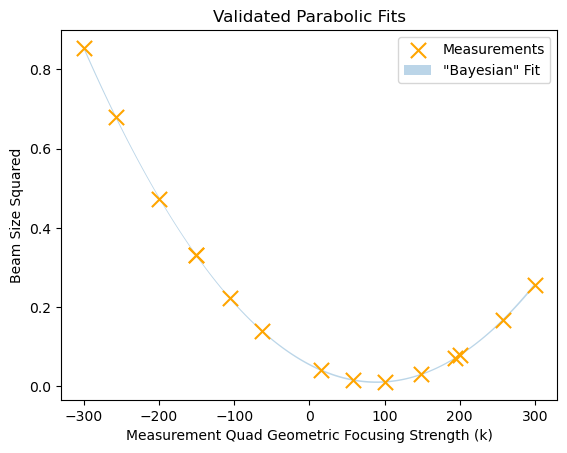

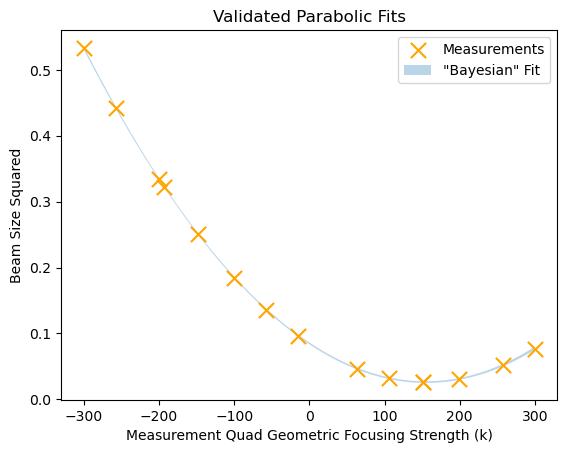

In [4]:
emit_vocs = VOCS(
        variables = {SCAN_VARIABLE: VARIABLE_RANGES[SCAN_VARIABLE]},
        objectives = {"rms_x":"MINIMIZE"},
        constraints = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", 4]
        },
        constants = opt_x.data.iloc[-1][TUNING_VARIABLES].to_dict() + {
            "screen": SCREEN_NAME,
            "background": BACKGROUND_FILE,
            "threshold": THRESHOLD,
            "roi": ROI
        }
    )

emit_results, emit_Xopt = characterize_emittance(
    emit_vocs,
    eval_beamsize,
    QUAD_LENGTH,
    DRIFT_LENGTH,
    quad_strength_key=SCAN_VARIABLE,
    rms_x_key="S_x_mm",
    rms_y_key="S_y_mm",
    quad_scan_analysis_kwargs={"visualize": True}
)

In [5]:
emit_results

{'x_emittance_median': 0.09838814303540569,
 'x_emittance_05': 0.09089812950826795,
 'x_emittance_95': 0.10501890293244567,
 'y_emittance_median': 0.10128098400946356,
 'y_emittance_05': 0.09938443771144555,
 'y_emittance_95': 0.10316152949286261}

In [6]:
emit_Xopt.data

,k4,k1,k2,k3,m11,m22,total_size,rms_x,rms_y,xopt_runtime,xopt_error
1,193.291371,31.948862,-83.970159,85.270135,7.188543e-08,3.225033e-07,0.000628,0.268115,0.567894,0.001702,False
2,-151.220257,31.948862,-83.970159,85.270135,3.311963e-07,2.672865e-08,0.000598,0.575497,0.163489,0.001804,False
3,200.218834,31.948862,-83.970159,85.270135,8.009496e-08,3.344607e-07,0.000644,0.283011,0.578326,0.001586,False
4,-151.367874,31.948862,-83.970159,85.270135,3.315912e-07,2.672606e-08,0.000599,0.575840,0.163481,0.001657,False
5,-199.541455,31.948862,-83.970159,85.270135,4.736290e-07,3.148750e-08,0.000711,0.688207,0.177447,0.001658,False
6,15.151520,31.948862,-83.970159,85.270135,4.154751e-08,9.684763e-08,0.000372,0.203832,0.311204,0.001277,False
7,-300.000000,31.948862,-83.970159,85.270135,8.546222e-07,7.719957e-08,0.000965,0.924458,0.277848,0.001716,False
8,300.000000,31.948862,-83.970159,85.270135,2.561707e-07,5.333678e-07,0.000889,0.506133,0.730320,0.001544,False
9,100.000000,31.948862,-83.970159,85.270135,1.244924e-08,1.847454e-07,0.000444,0.111576,0.429820,0.001276,False
10,-63.636368,31.948862,-83.970159,85.270135,1.401053e-07,4.685445e-08,0.000432,0.374306,0.216459,0.001725,False
